In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *
import utils.vision_transformer as VT

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Compute Model Parameters (Spectrogram Shape)

In [23]:
person = 'm7'
action_name = "walk_0621_0422"
file_path = f'./data/all/{person}/{action_name}.csv'

# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True
byCol=True
align=False
features = ['Q', 'omega', 'omega_l2']

spectrograms_file, gts_file, times_file = prepare_file(file_path, features=features, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1, byCol=byCol, align=align)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

----------------------------
sepctrograms:(22, 16, 65, 3)
gt:(22, 1)
times:(22, 1)


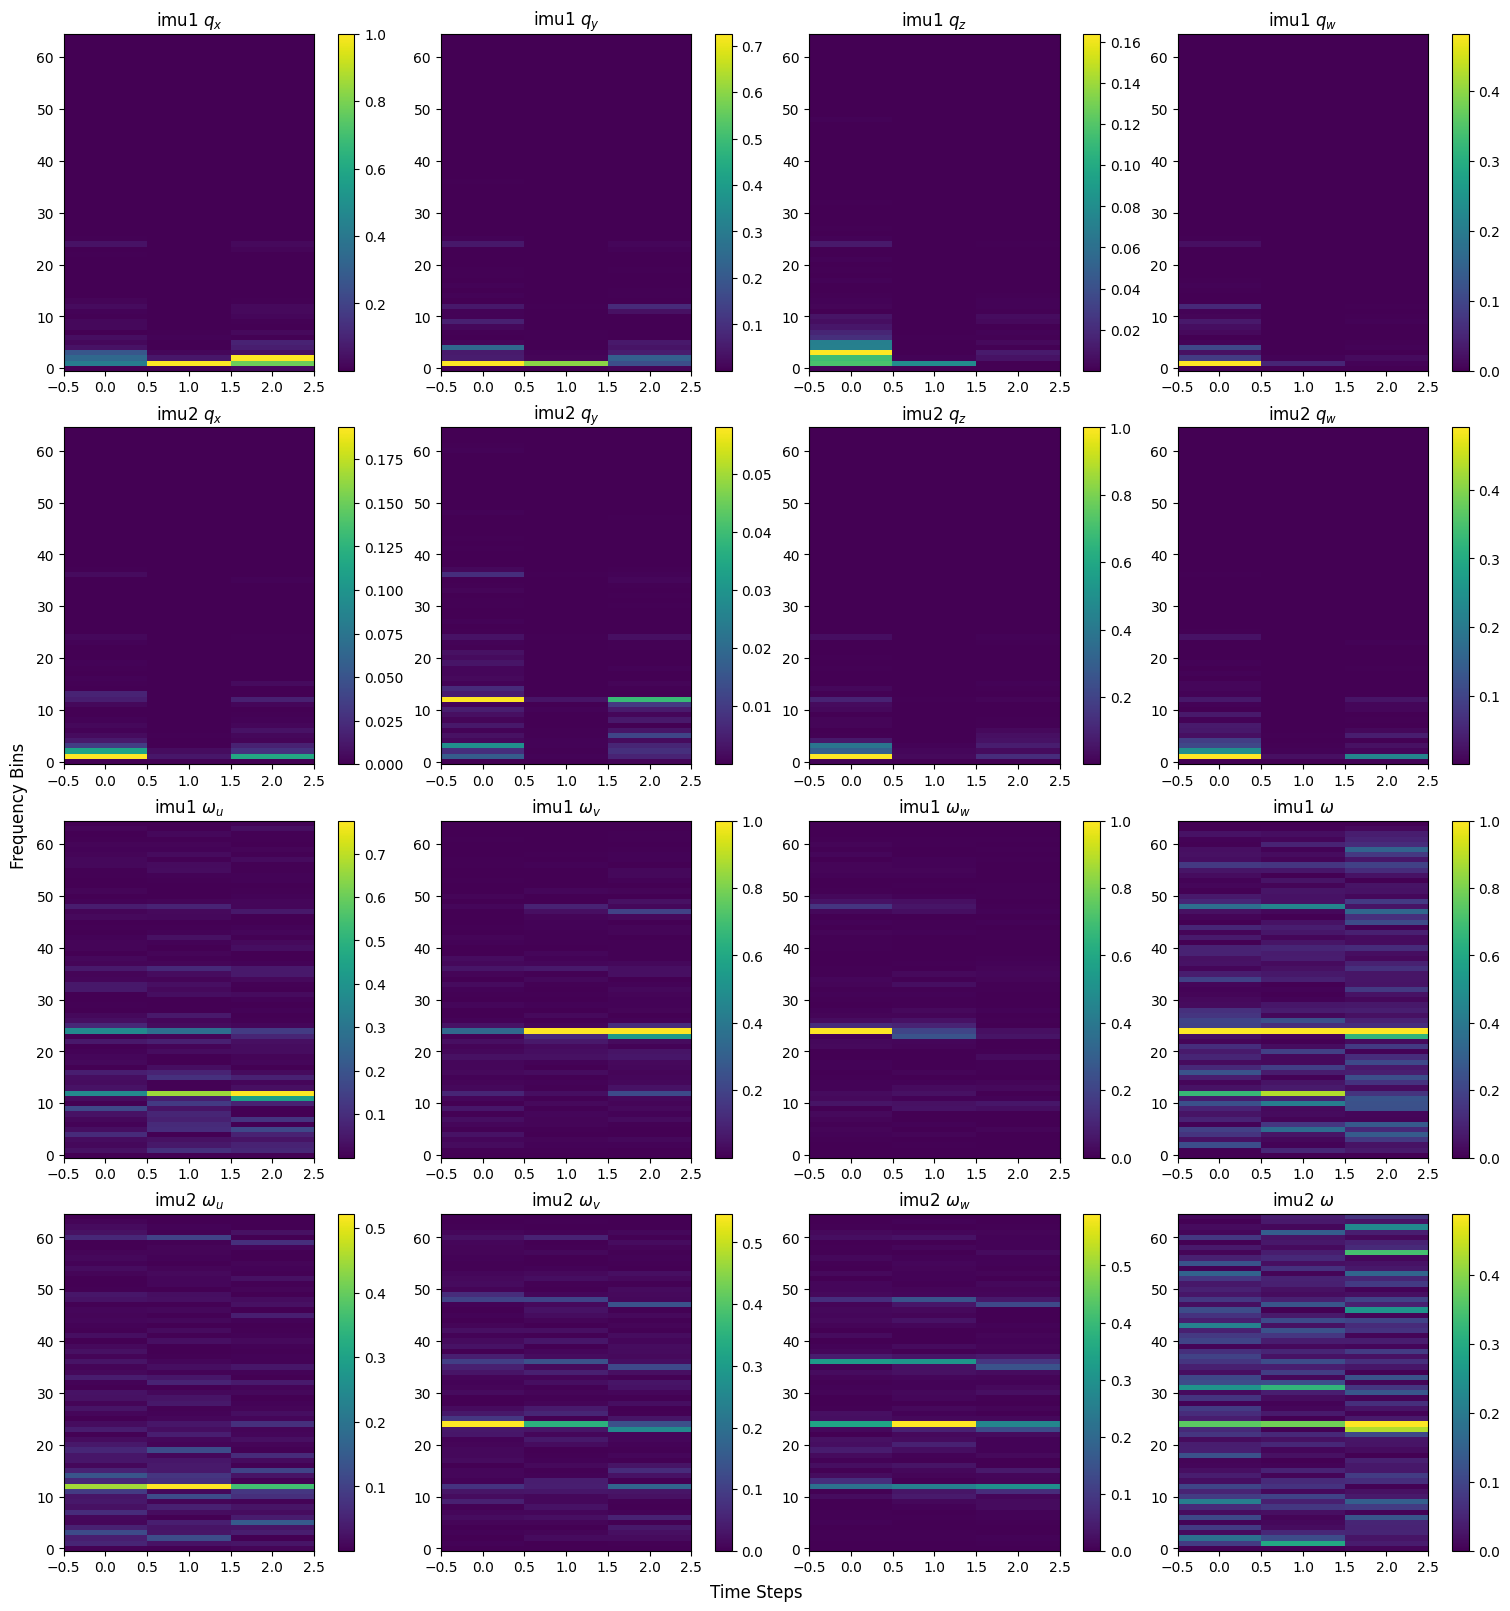

In [24]:
# show one spectrogram
plot_spectrogram(spectrograms_file[10], features=features)

In [25]:
torch.cuda.is_available()

True

## Testing Model

In [26]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "17PR"
test_set=['m2', 'm5', 'm7', 'w1', 'w4']
features = ['Q', 'omega', 'omega_l2']

dataset = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}.pkl'), 'rb'))
_, _, input_test, gt_test = split_dataset(dataset, test_set=test_set, features=features)

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

Testing data......
Testing shape: (458, 16, 65, 3)


In [27]:
# Test one file
person = 'm7'
action_name = "walk_0621_0422"
path_file = f'./data/all/{person}/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, features=features, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True, align=align)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

----------------------------
sepctrograms:(22, 16, 65, 3)
gt:(22, 1)
times:(22, 1)


In [28]:
# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_name = ['MLP_17PR_16', 'CNN_17PR_16', 'VT_17PR_16_s']
models_name_show = ["MLP", "CNN", "ViT"]

# models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
#           CNN_out1_2(num_channels=num_channels),
#           VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=128, mlp_dim=256, num_heads=4, num_layers=2, device=device, model_name='VT_17PR_Q_emb128_mlp256_nl2'),]

models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=64, mlp_dim=128, num_heads=2, num_layers=2, device=device, load=True, model_name='VT_17PR_16_s'),]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_17PR_16 Evaluation Results - MSE Loss: 25.2146, L1 Loss: 3.3146 1/min
CNN_17PR_16 Evaluation Results - MSE Loss: 21.9608, L1 Loss: 3.3710 1/min
VT_17PR_16_s Evaluation Results - MSE Loss: 19.7141, L1 Loss: 3.2740 1/min


MLP Evaluation Results - MSE Loss: 0.0106, L1 Loss: 5.1264 1/min, R²:-2.1501
CNN Evaluation Results - MSE Loss: 0.0051, L1 Loss: 3.1647 1/min, R²:-0.5285
ViT Evaluation Results - MSE Loss: 0.0075, L1 Loss: 4.7776 1/min, R²:-1.2471


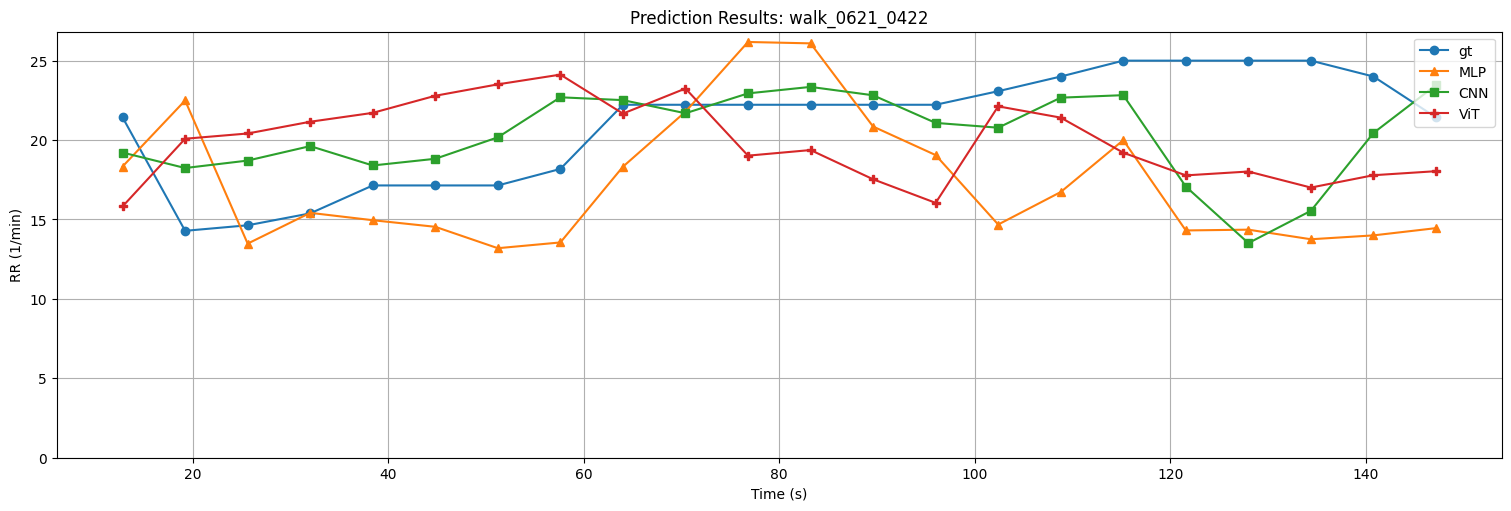

In [29]:
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=models_name_show, gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [30]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "17PR"
test_set=['m2', 'm5', 'm7', 'w1', 'w4']
features = ['Q', 'omega', 'omega_l2']

dataset = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}.pkl'), 'rb'))
_, _, input_test, gt_test = split_dataset(dataset, test_set=test_set, features=features, ByAction=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

action_order = ['sit', 'stand', 'walk', 'run']
input_test = {k : input_test[k] for k in action_order}
gt_test = {k : gt_test[k] for k in action_order}
print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk
action: run


MLP
sit - MSE Loss: 0.0014, L1 Loss: 1.5578 1/min
stand - MSE Loss: 0.0021, L1 Loss: 1.8419 1/min
walk - MSE Loss: 0.0185, L1 Loss: 6.0840 1/min
run - MSE Loss: 0.0062, L1 Loss: 3.7102 1/min

CNN
sit - MSE Loss: 0.0023, L1 Loss: 1.8583 1/min
stand - MSE Loss: 0.0019, L1 Loss: 1.9528 1/min
walk - MSE Loss: 0.0160, L1 Loss: 6.4389 1/min
run - MSE Loss: 0.0045, L1 Loss: 3.2532 1/min

ViT
sit - MSE Loss: 0.0029, L1 Loss: 2.2051 1/min
stand - MSE Loss: 0.0020, L1 Loss: 1.8401 1/min
walk - MSE Loss: 0.0130, L1 Loss: 5.8246 1/min
run - MSE Loss: 0.0042, L1 Loss: 3.2328 1/min



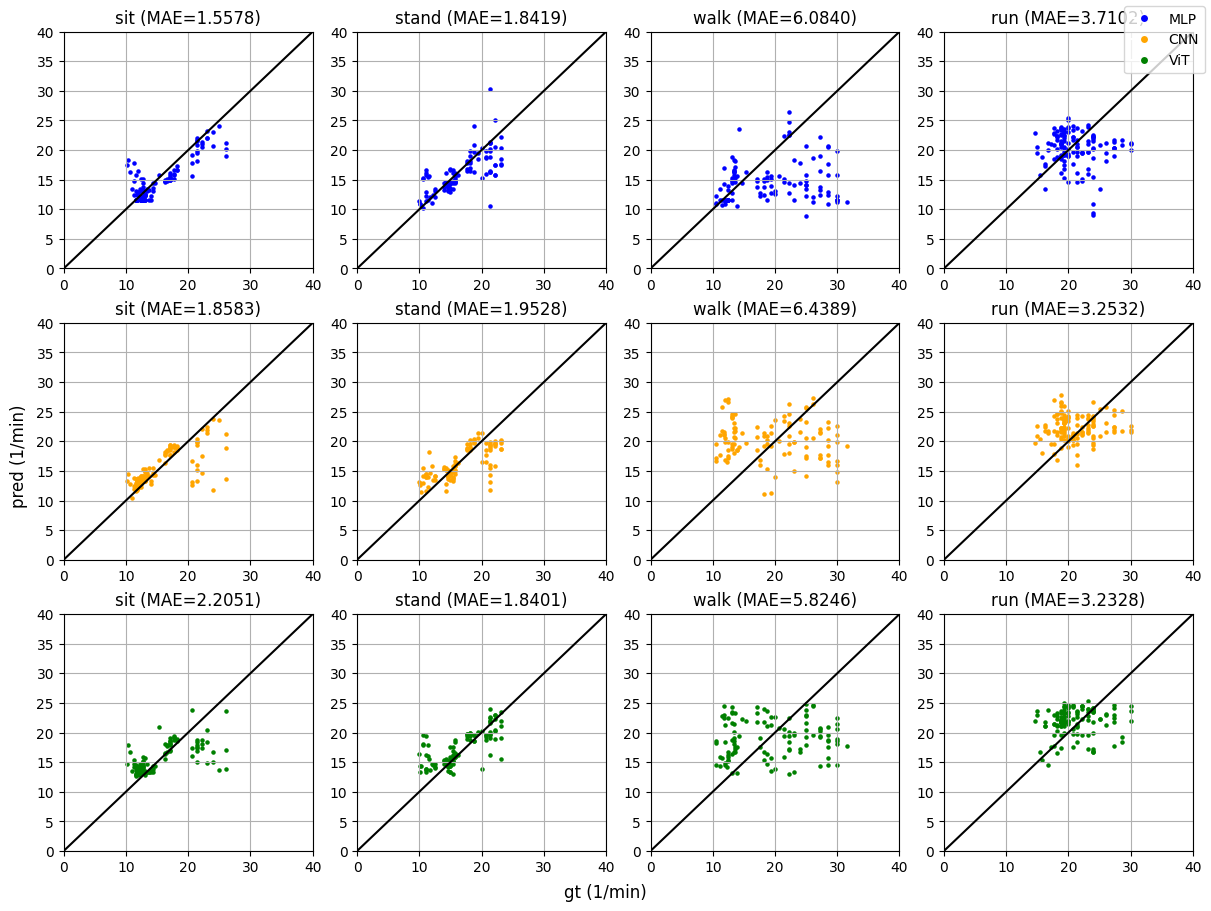

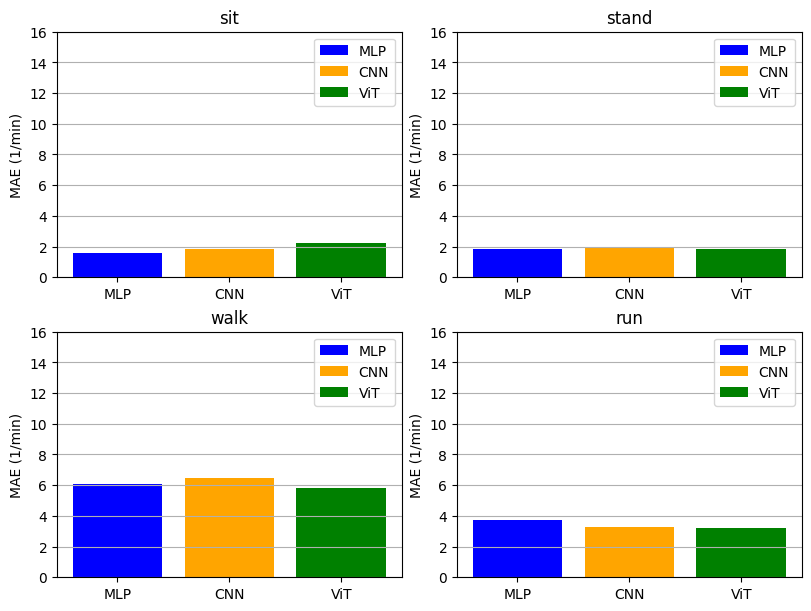

In [31]:
evaluate_models_action(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)

MLP
sit - MSE Loss: 0.0014, L1 Loss: 1.5578 1/min E%: 10.5610%
stand - MSE Loss: 0.0021, L1 Loss: 1.8419 1/min E%: 11.0458%
walk - MSE Loss: 0.0185, L1 Loss: 6.0840 1/min E%: 27.0242%
run - MSE Loss: 0.0062, L1 Loss: 3.7102 1/min E%: 17.2978%

CNN
sit - MSE Loss: 0.0023, L1 Loss: 1.8583 1/min E%: 11.1589%
stand - MSE Loss: 0.0019, L1 Loss: 1.9528 1/min E%: 12.1762%
walk - MSE Loss: 0.0160, L1 Loss: 6.4389 1/min E%: 38.3870%
run - MSE Loss: 0.0045, L1 Loss: 3.2532 1/min E%: 16.2662%

ViT
sit - MSE Loss: 0.0029, L1 Loss: 2.2051 1/min E%: 13.6473%
stand - MSE Loss: 0.0020, L1 Loss: 1.8401 1/min E%: 13.1425%
walk - MSE Loss: 0.0130, L1 Loss: 5.8246 1/min E%: 32.6477%
run - MSE Loss: 0.0042, L1 Loss: 3.2328 1/min E%: 15.7440%



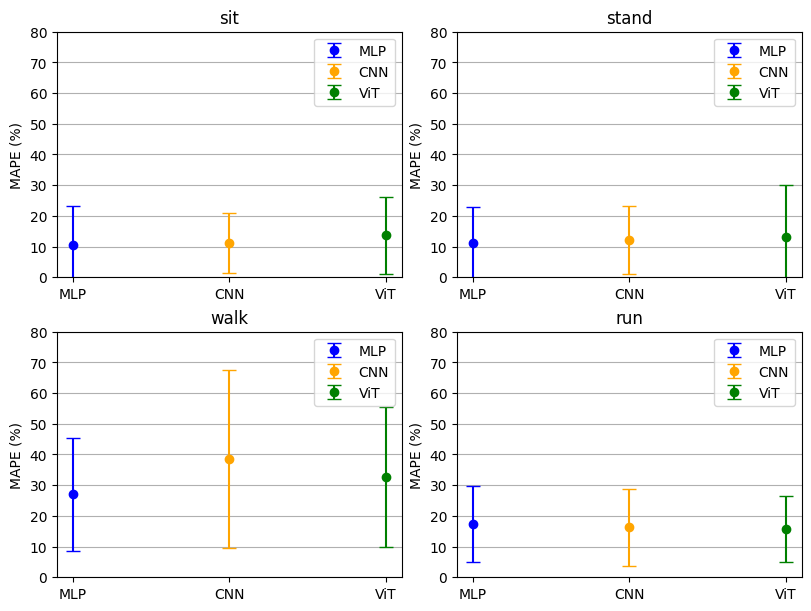

In [32]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)